#SISTEMA DE IA PARA TRIAJE DE PACIENTES CON TENDINOPATÍA CALCIFICADA DEL MANGUITO ROTADOR



##Javier Pozo y Javier Álvarez

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -uq '/content/drive/MyDrive/Colab/HURJC/database_numbers_new.zip'

Cargamos los módulos necesarios

In [3]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import os, warnings
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import math
import skimage.exposure
from skimage.transform import resize
from skimage.color import rgb2gray

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout
import glob
import seaborn as sns
import cv2

%matplotlib inline

#1. Carga de etiquetas e imágenes

Leemos el excel que contiene los datos de nuestra base de datos y las distintas etiquetas

In [4]:
labels_df = pd.read_excel('/content/drive/MyDrive/Colab/HURJC/database_new.xlsx')

In [5]:
labels = np.array(labels_df['calcium'].tolist())
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


Realizamos un análisis descriptivo de nuestros datos

In [6]:
labels_df.tail(20)

image  calcium pat_id  type localization  letras
136  137.png        0    NaN   NaN          NaN       1
137  138.png        0    NaN   NaN          NaN       1
138  139.png        0    NaN   NaN          NaN       1
139  140.png        0    NaN   NaN          NaN       1
140  141.png        0    NaN   NaN          NaN       1
141  142.png        0    NaN   NaN          NaN       1
142  143.png        0    NaN   NaN          NaN       1
143  144.png        0    NaN   NaN          NaN       1
144  145.png        0    NaN   NaN          NaN       1
145  146.png        0    NaN   NaN          NaN       1
146  147.png        0    NaN   NaN          NaN       1
147  148.png        0    NaN   NaN          NaN       1
148  149.png        0    NaN   NaN          NaN       1
149  150.png        0    NaN   NaN          NaN       1
150  151.png        0    NaN   NaN          NaN       1
151  152.png        0    NaN   NaN          NaN       1
152  153.png        0    NaN   NaN          NaN       1
153  154.png        0    NaN   NaN          NaN       1
154  155.png        0    NaN   NaN          NaN       1
155  156.png        0    NaN   NaN          NaN       1

In [7]:
labels_df.describe()

calcium        type      letras
count  156.00000  100.000000  156.000000
mean     0.50000    1.550000    0.711538
std      0.50161    1.635311    0.454506
min      0.00000   -1.000000    0.000000
25%      0.00000    1.000000    0.000000
50%      0.50000    2.000000    1.000000
75%      1.00000    3.000000    1.000000
max      1.00000    4.000000    1.000000

La base de datos está balanceada: 78 imágenes con calcio y 78 sin calcio

In [8]:
labels_df['calcium'].value_counts()

1    78
0    78
Name: calcium, dtype: int64

Contamos las imágenes que incluyen una etiqueta en ella, para eliminar posteriormente la etiqueta

In [9]:
labels_df['letras'].value_counts() #contamos las imagenes que incluyen etiquetas

1    111
0     45
Name: letras, dtype: int64

In [10]:
files = sorted(glob.glob('/content/database_numbers/*.png'))

#2. Preprocesado de las imágenes

Leemos las imagenes y eliminamos las etiquetas en aquellas imágenes en las que aparece un 1 en el apartado 'letras'. Posteriormente, las redimensionamos a 224x224, que es el tamaño con el que se entrenaron las imágenes de ImageNet en VGG16 (Transfer Learning).

In [11]:
images = []
i = 0
while i < 156:
  for path in files:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if labels_df['letras'][i] == 1:

      # Binary threshold image
      mask = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY)[1]

      # Remove small noise
      inp_mask = cv2.morphologyEx(mask,
                                  cv2.MORPH_OPEN,
                                  cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2)))

      # Dilate mask
      inp_mask = cv2.dilate(inp_mask,
                            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)))

      # Inpaint
      dst = cv2.inpaint(img, inp_mask, 15, cv2.INPAINT_NS)
    
      images.append(resize(dst,(224,224,3)))
      i = i+1

    else:
      images.append(resize(img,(224,224,3)))
      i = i+1


In [12]:
images_array = np.array(images) #convertimos las imagenes en arrays

In [13]:
np.max(images_array[0])

0.7877171180972389

In [14]:
images_array.shape

(156, 224, 224, 3)

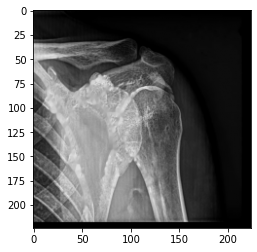

In [15]:
plt.imshow(images_array[40])

La siguiente celda representa lo que le hemos hecho a las imágenes para eliminar las etiquetas

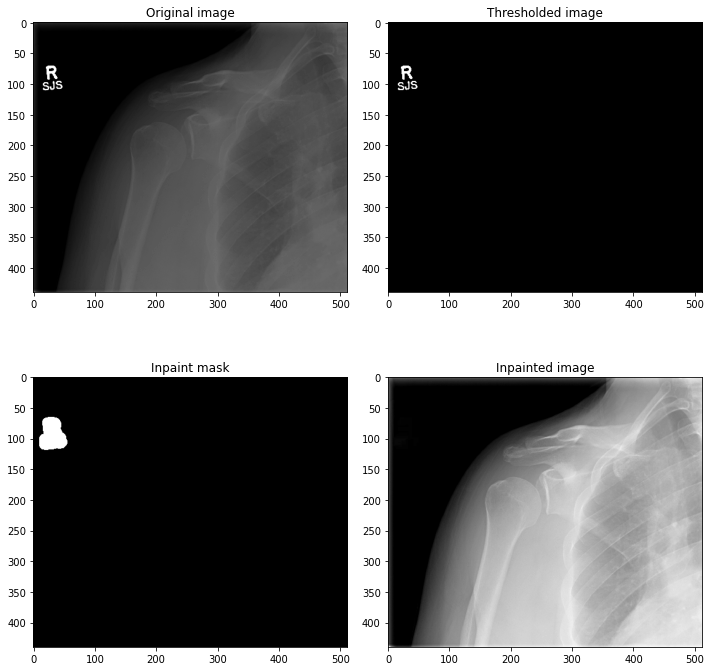

In [16]:

img = cv2.imread(files[150], cv2.IMREAD_GRAYSCALE)

# Binary threshold image
mask = cv2.threshold(img, 245, 255, cv2.THRESH_BINARY)[1]

# Remove small noise
inp_mask = cv2.morphologyEx(mask,
                            cv2.MORPH_OPEN,
                            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2)))

# Dilate mask
inp_mask = cv2.dilate(inp_mask,
                      cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)))

# Inpaint
dst = cv2.inpaint(img, inp_mask, 15, cv2.INPAINT_NS)

# Show results
plt.figure(1, figsize=(10, 10))
plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray'), plt.title('Original image')
plt.subplot(2, 2, 2), plt.imshow(mask, cmap='gray'), plt.title('Thresholded image')
plt.subplot(2, 2, 3), plt.imshow(inp_mask, cmap='gray'), plt.title('Inpaint mask')
plt.subplot(2, 2, 4), plt.imshow(dst, cmap='gray'), plt.title('Inpainted image')
plt.tight_layout()
plt.show()


In [17]:
print(labels)
print(labels.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
(156,)


Realizamos una división de las imágenes inicialmente en 2 conjuntos: train_validation (80%) y test (20%).

In [18]:
indices = range(1, 157)
train_validationX, testX, train_validationY, testY, train_indices, test_indices = train_test_split(images_array, labels, indices, test_size=0.2, random_state=4)

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)

(124, 224, 224, 3) (32, 224, 224, 3)
(124,) (32,)


In [19]:
print((test_indices))

[129, 122, 35, 26, 20, 70, 107, 13, 46, 94, 25, 100, 15, 137, 61, 42, 19, 6, 47, 12, 27, 120, 7, 3, 155, 133, 48, 112, 30, 131, 81, 64]


Ahora procedemos a realizar la partición de aprendizaje y validación (90% y 10%) del conjunto obtenido anteriormente (train_validation)

In [20]:
trainX, validX, trainY, validY = train_test_split(train_validationX, train_validationY, test_size=0.1, random_state=0)
print(trainX.shape, validX.shape)
print(trainY.shape, validY.shape)

(111, 224, 224, 3) (13, 224, 224, 3)
(111,) (13,)


In [21]:
print(testY)
print(validY)
print(trainY)

[0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1]
[1 1 1 1 1 0 0 1 1 0 1 1 1]
[0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0
 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1
 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0]


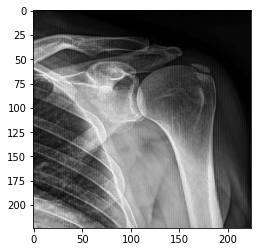

In [22]:
plt.imshow(testX[3])

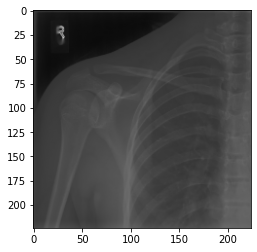

In [23]:
plt.imshow(trainX[1])

Procedemos a hacer Data Augmentation de las imágenes de aprendizaje y validación, que consiste en la modificación de las imágenes de nuestro conjunto de entrenamiento para posteriormente añadirlas al mismo conjunto y aumentar el número de imágenes con el que entrenaremos el modelo, con el propósito de mejorar las prestaciones de este y reducir el overfitting. Esta adición no se debe hacer en el conjunto de test. Para esto usamos ImageDataGenerator, con el que generaremos las imágenes atendiendo a los parámetros que le indiquemos.

In [24]:
train_image_data = ImageDataGenerator(
    zoom_range=0.05, #Zoom aleatorio sobre las imágenes
    rotation_range=40, #Rotación de las imágenes
    width_shift_range=0.05, #Fracción de anchura total
    height_shift_range=0.05, #Fracción de altura total
    horizontal_flip=True, #Voltear horizontalmente
    fill_mode='constant', #Tipo de relleno para los inputs que están fuera de los límites
    cval=0 #Valor usado para rellenar los inputs fuera de los límites
)
validation_image_data = ImageDataGenerator(
    zoom_range=0.05,
    rotation_range=40,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)
test_datagen = ImageDataGenerator(rescale=1./255)

Mostramos algunos ejemplos de las imágenes que estamos generando con el DataAugmentation

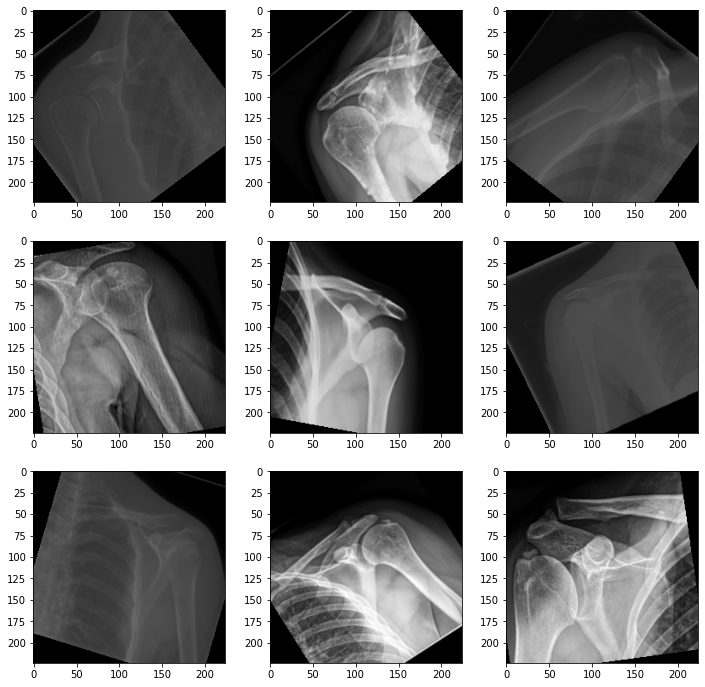

In [25]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i],cmap='gray')
    plt.show()
    break

#3. Diseño de la red convolucional

Primero, creamos una función que nos devuelve una matriz de confusión para asi valorar después del entrenamiento las prestaciones de nuestro modelo

In [26]:
from sklearn.metrics import classification_report
def check_accuracy(model, setX, actual, print_images=True): 
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)]) #Guardamos en la variable predicted la predicción (0 o 1) de nuestro modelo sobre las imágenes
    if print_images: #Generamos las imágenes con la etiqueta predicha y la verdadera
        rows = math.ceil(len(predicted)/10.) 
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)): 
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
    target_names = ['class 0', 'class 1'] 
    print(classification_report(actual, predicted, target_names=target_names))    
    confusion = confusion_matrix(actual, predicted) #Guardamos en confusion la matriz de confusión generada
    tn, fp, fn, tp = confusion.ravel() #Asignamos cada elemento de la matriz
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%") 
    return (tn, fp, fn, tp)

Creamos un callback (modelcheckpoint) del que haremos uso más adelante al entrenar nuestra base de datos. Este guardará los pesos del entrenamiento de todas las epochs para poder posteriormente obtener los pesos de la epoch que nos interese.

In [27]:
checkpoint_filepath = '/content/drive/MyDrive/Colab/HURJC/checkpoint_filepath2/nnweights-{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=False)

Importamos la arquitectura VGG16, que utilizaremos para hacer Transfer Learning a nuestro modelo

In [28]:
from tensorflow.keras.applications import VGG16


In [29]:
inp = layers.Input(shape=(224, 224, 3))
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inp,
                   input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 0s 0us/step


Vemos cómo está estructurada la VGG16:

In [30]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Creamos las capas que vamos a añadir posteriormente, y congelamos los pesos de la base preentrenada. Este modelo ha sido entrenado en la base de datos ImageNet, por lo que transferimos esos pesos a nuestro modelo.


In [31]:
flat = layers.Flatten()
dropped = layers.Dropout(0.3)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
BN = layers.BatchNormalization()

fc1 = layers.Dense(256, activation='relu', name='dense_1')
prediction = layers.Dense(1, activation='sigmoid', name='output')

#Congelamos los pesos de la base preentrenada

for layr in base_model.layers:
    if ('flatten_1' in layr.name):

        layr.trainable = True
    else:
        layr.trainable = False


Añadimos al final una fully connected layer, que consiste en una capa de 256 filtros con la función de activación 'relu', y posteriormente un Batch Normalization y un Dropout. Finalmente declaramos nuestra capa de salida, que solamente consta de 1 filtro ya que es clasificación binaria, con la función de activación 'sigmoid'.

In [32]:
block5_pool = base_model.get_layer('block5_pool')

x = flat(block5_pool.output)
x = fc1(x)
x = BN(x)
x = dropped(x)
x = prediction(x)



Compilamos nuestro modelo. Utilizamos con función de pérdida la binary crossentropy, como optimizador el Adam, y como métrica, la binary acurracy.

In [33]:
model = tf.keras.models.Model(inputs = inp, outputs = x)
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Aplicamos el Data Augmentation a nuestros conjuntos de aprendizaje y validación y establecemos el tamaño del batch para el entrenamiento

In [35]:
train_batch_size = 9
val_batch_size = 8

train_generator = train_image_data.flow(
    trainX,
    trainY,
    batch_size=train_batch_size)

validation_generator = validation_image_data.flow( 
    validX,
    validY,
    batch_size=val_batch_size)

In [ ]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(trainY), 
                trainY) 
class_weights = {i : class_weights[i] for i in range(2)}
class_weights

{0: 0.925, 1: 1.088235294117647}

Entrenamos el modelo con 100 epochs

In [ ]:
steps_per_epoch = train_generator.n // train_batch_size
validation_steps = validation_generator.n // val_batch_size

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    callbacks=model_checkpoint_callback,
                    #class_weight=class_weights,
                    epochs=100)

Epoch 1/100
12/12 [==============================] - 14s 373ms/step - loss: 0.8456 - binary_accuracy: 0.6424 - val_loss: 1.6088 - val_binary_accuracy: 0.8750
Epoch 2/100
12/12 [==============================] - 1s 111ms/step - loss: 0.5249 - binary_accuracy: 0.8303 - val_loss: 0.0012 - val_binary_accuracy: 1.0000
Epoch 3/100
12/12 [==============================] - 1s 108ms/step - loss: 0.4952 - binary_accuracy: 0.8011 - val_loss: 0.4612 - val_binary_accuracy: 0.8750
Epoch 4/100
12/12 [==============================] - 1s 110ms/step - loss: 0.2714 - binary_accuracy: 0.8803 - val_loss: 0.7835 - val_binary_accuracy: 0.8750
Epoch 5/100
12/12 [==============================] - 1s 106ms/step - loss: 0.3186 - binary_accuracy: 0.8573 - val_loss: 0.5194 - val_binary_accuracy: 0.8750
Epoch 6/100
12/12 [==============================] - 1s 108ms/step - loss: 0.1813 - binary_accuracy: 0.9247 - val_loss: 0.7655 - val_binary_accuracy: 0.8750
Epoch 7/100
12/12 [==============================] - 1s 1

# 4. Resultados

Realizamos una gráfica con la evolución del proceso de aprendizaje, observando la accuracy y la pérdida, tanto en entrenamiento como en validación.

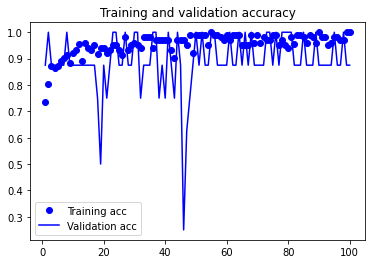

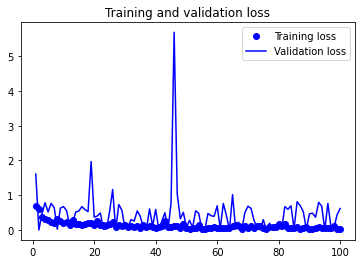

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

Realizamos un suavizado de las curvas para observar de manera más clara la evolución del proceso.

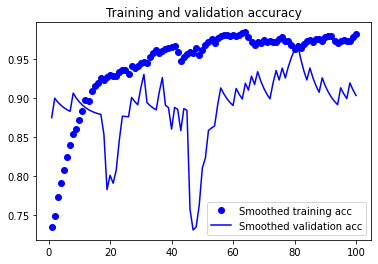

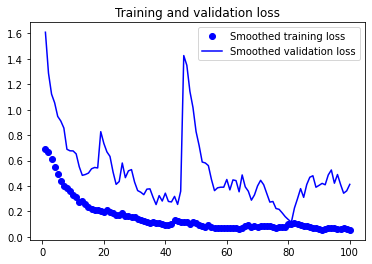

In [ ]:
def smooth_curve(points, factor=0.8): 
  smoothed_points = []
  for point in points:
      if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
      else: 
          smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss') 
plt.legend()
plt.show()

Podemos observar que nuestro modelo no ha sufrido overfitting. Esto es debido al uso de técnicas como el Data Augmentation y el Dropout.

Observamos la accuracy obtenida en la epoch 100:

              precision    recall  f1-score   support

     class 0       0.92      0.73      0.81        15
     class 1       0.80      0.94      0.86        17

    accuracy                           0.84        32
   macro avg       0.86      0.84      0.84        32
weighted avg       0.85      0.84      0.84        32

True positive: 16 , True negative: 11 , False positive: 4 , False negative: 1
Total accuracy: 84.375 %


(11, 4, 1, 16)

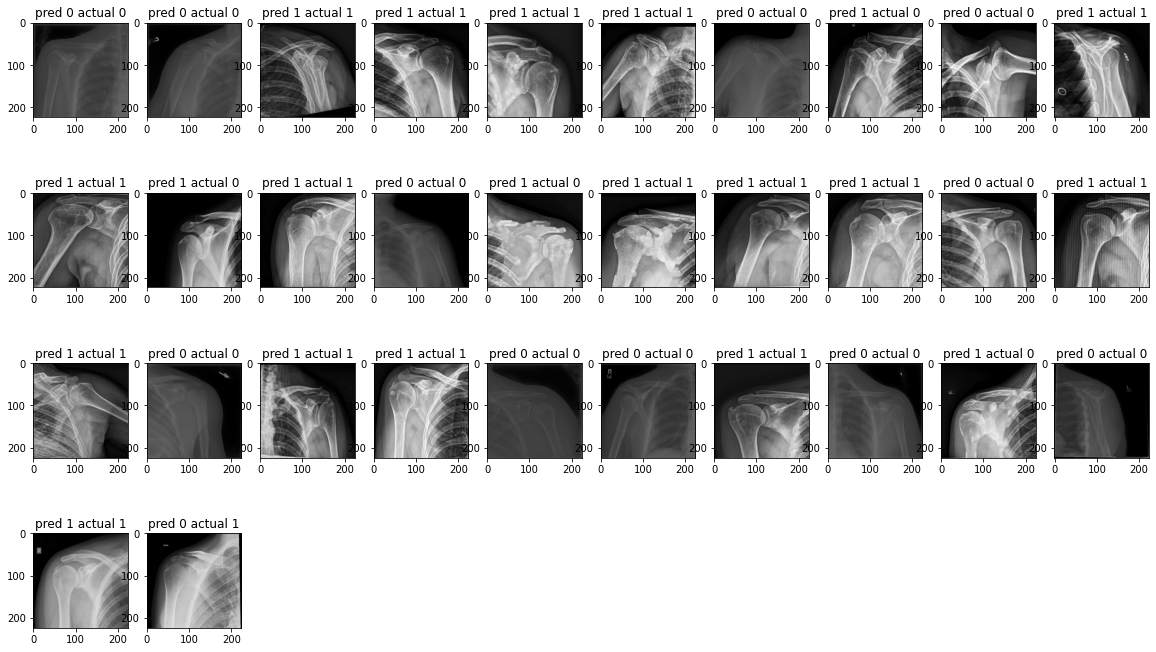

In [ ]:
check_accuracy(model, testX, testY)

Cargamos los pesos obtenidos en la epoch 81, ya que en el conjunto de validación tuvo una mayor accuracy y una loss menor

In [36]:
model.load_weights('/content/drive/MyDrive/Colab/HURJC/checkpoint_filepath2/nnweights-81-0.03.hdf5')

Observamos que la accuracy es mayor que en el caso anterior: 87,5%

              precision    recall  f1-score   support

     class 0       1.00      0.73      0.85        15
     class 1       0.81      1.00      0.89        17

    accuracy                           0.88        32
   macro avg       0.90      0.87      0.87        32
weighted avg       0.90      0.88      0.87        32

True positive: 17 , True negative: 11 , False positive: 4 , False negative: 0
Total accuracy: 87.5 %


(11, 4, 0, 17)

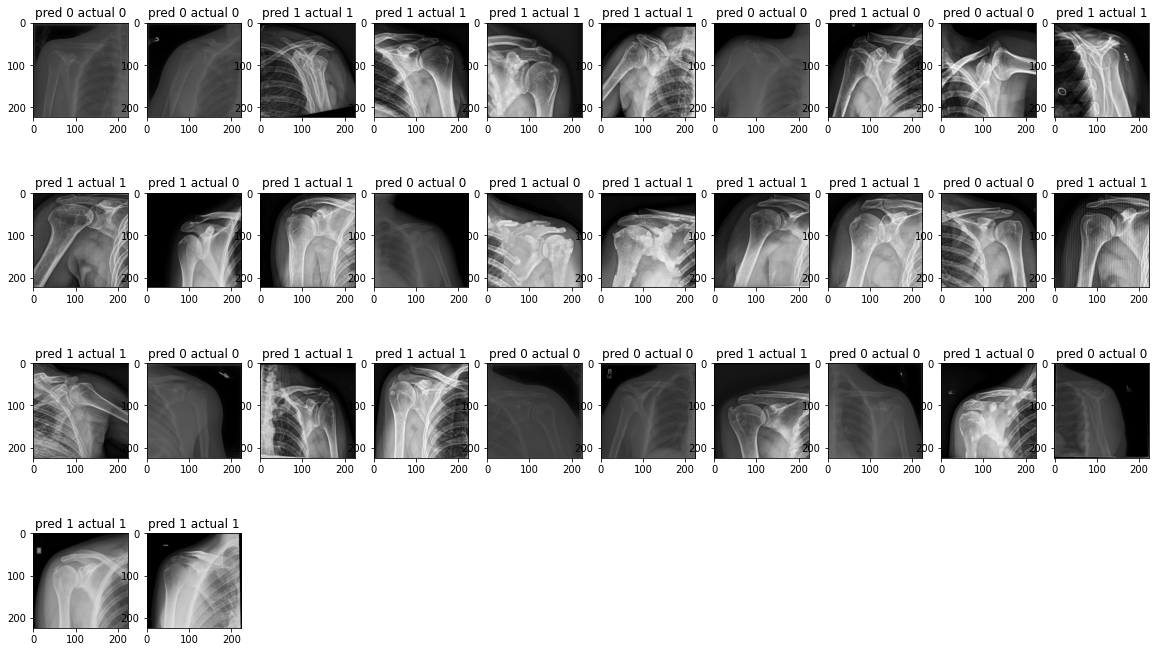

In [37]:
check_accuracy(model, testX, testY)

Creamos el CAM, para ver dónde se está fijando nuestro modelo a la hora de clasificar en calcio/no calcio

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 129 
Predice: 0 y es un 0


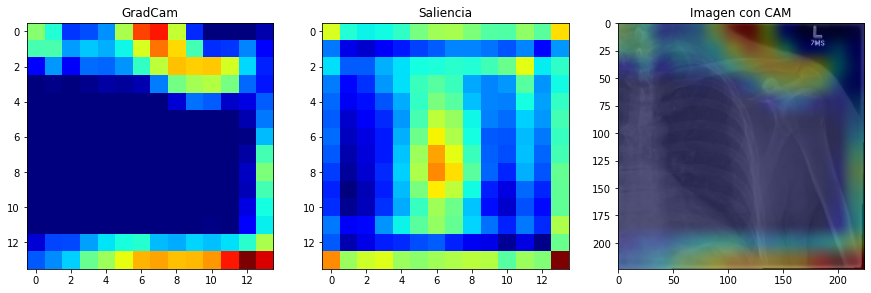

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 122 
Predice: 0 y es un 0


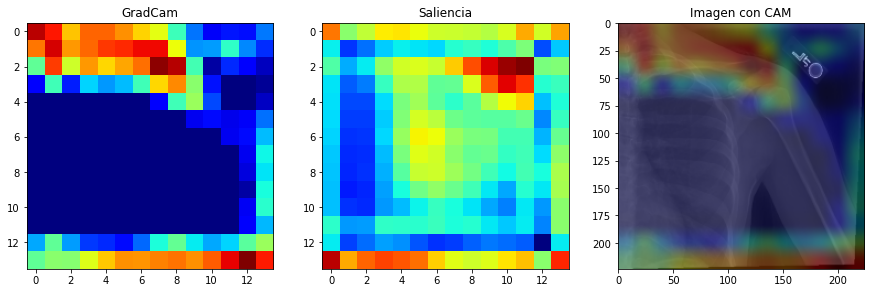

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 35 
Predice: 1 y es un 1


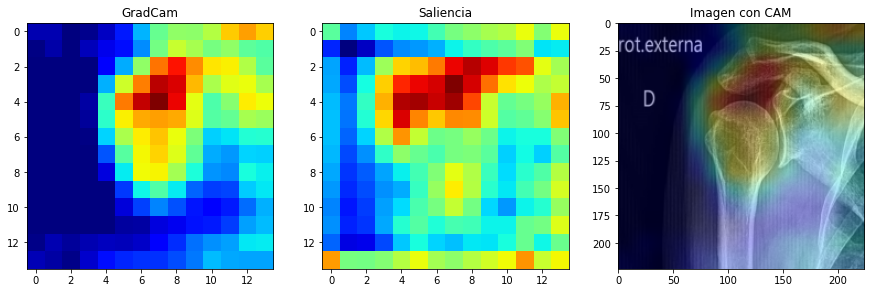

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 26 
Predice: 1 y es un 1


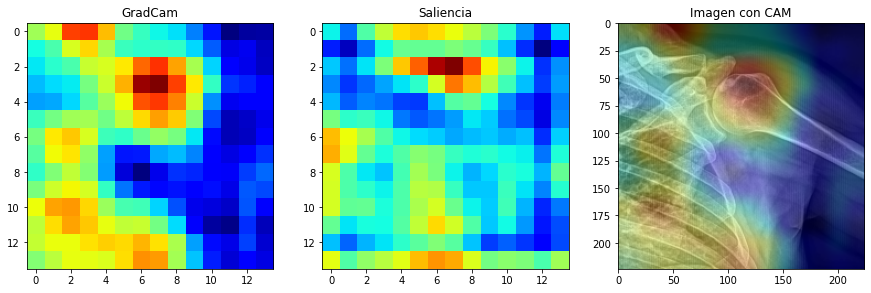

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 20 
Predice: 1 y es un 1


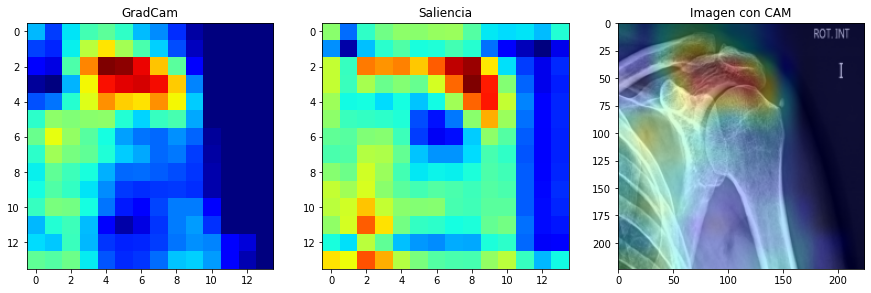

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 70 
Predice: 1 y es un 1


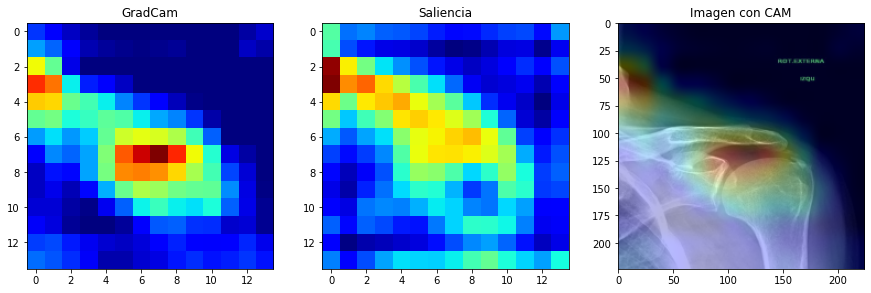

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 107 
Predice: 0 y es un 0


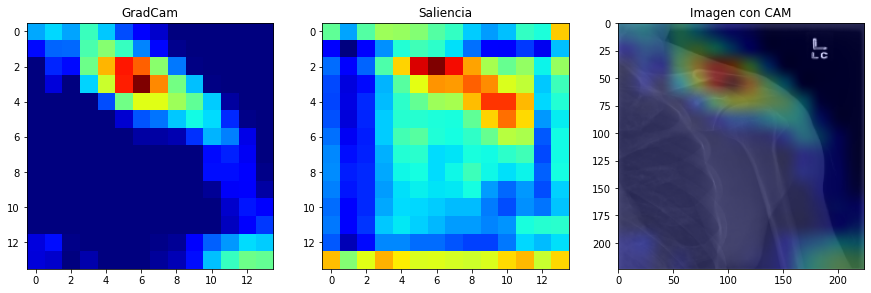

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 13 
Predice: 1 y es un 0


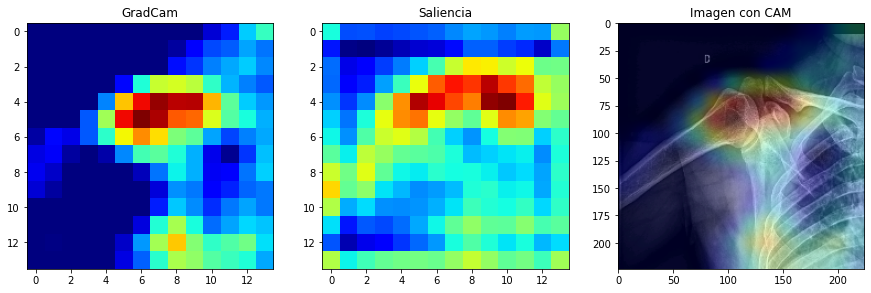

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 46 
Predice: 0 y es un 0


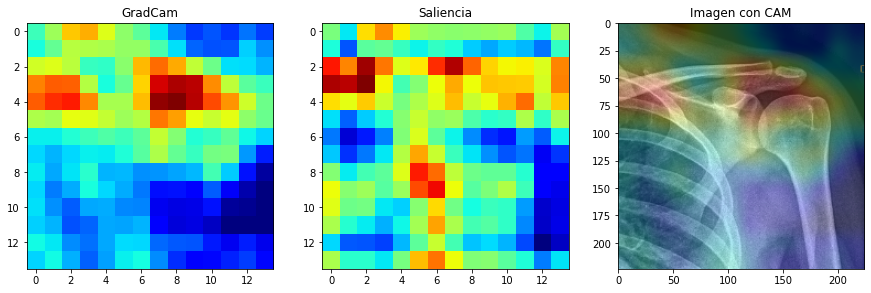

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 94 
Predice: 1 y es un 1


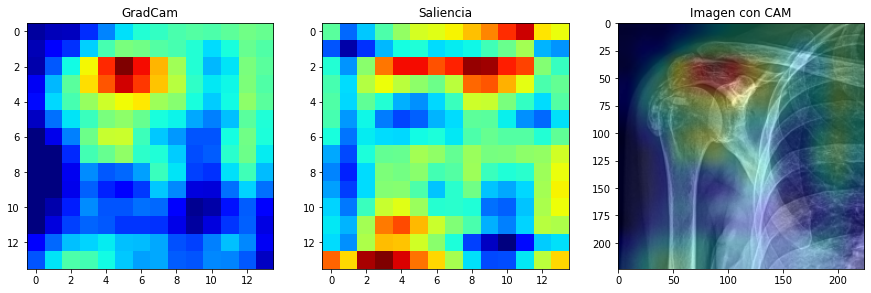

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 25 
Predice: 1 y es un 1


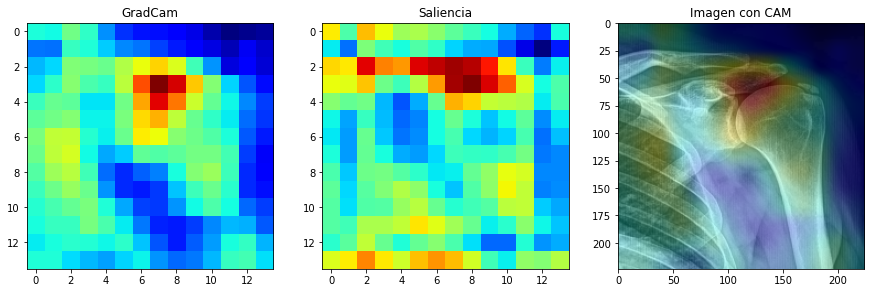

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 100 
Predice: 1 y es un 0


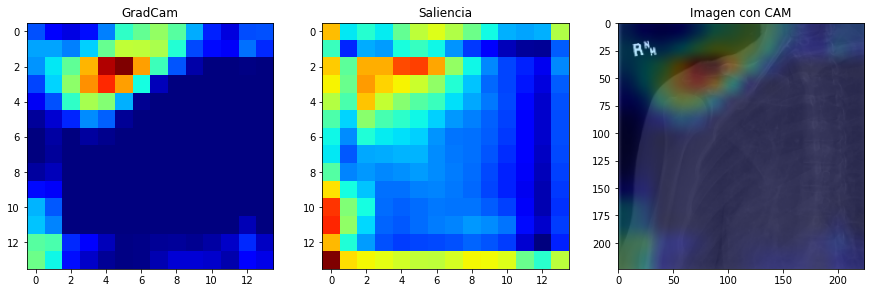

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 15 
Predice: 1 y es un 1


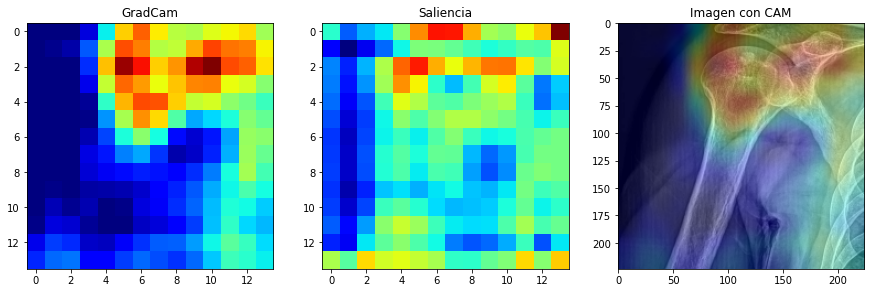

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 137 
Predice: 0 y es un 0


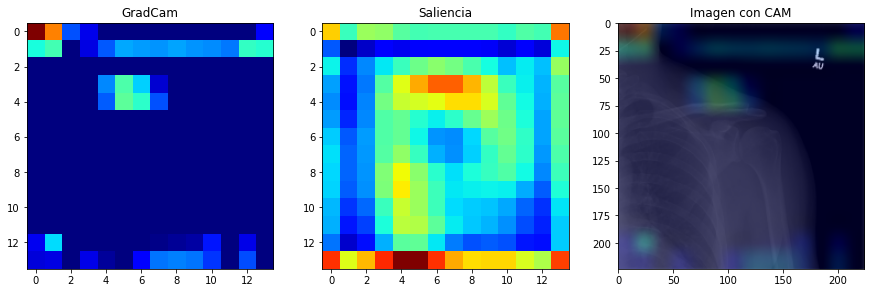

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 61 
Predice: 1 y es un 0


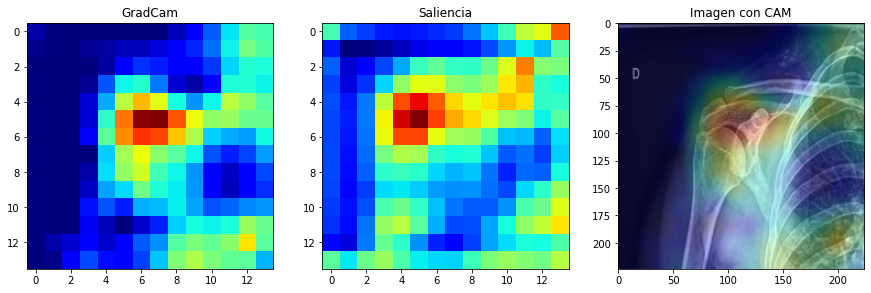

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 42 
Predice: 1 y es un 1


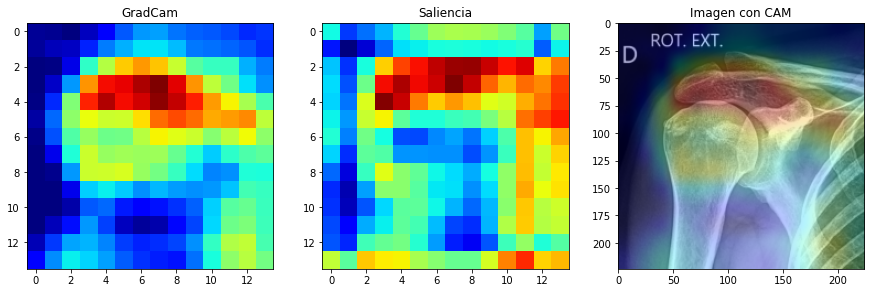

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 19 
Predice: 1 y es un 1


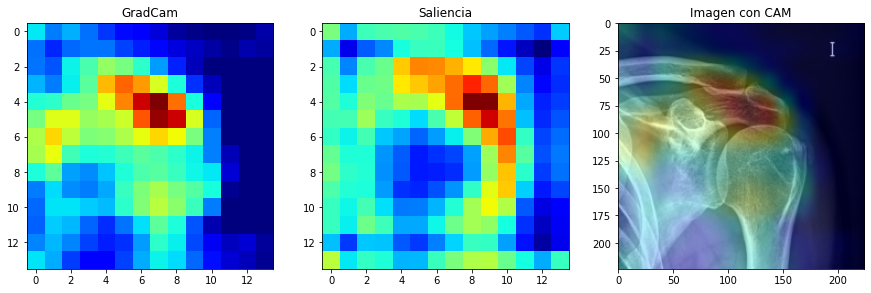

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 6 
Predice: 1 y es un 1


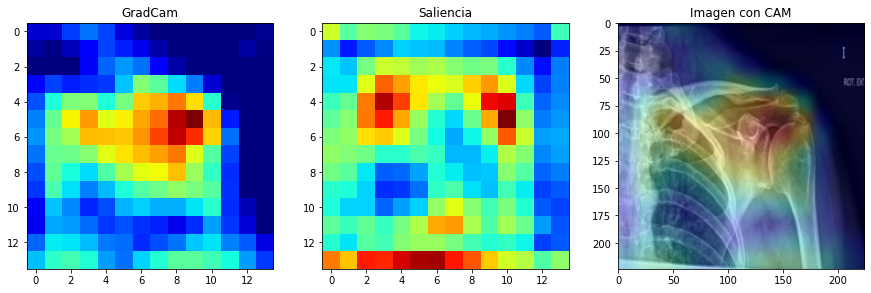

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 47 
Predice: 0 y es un 1


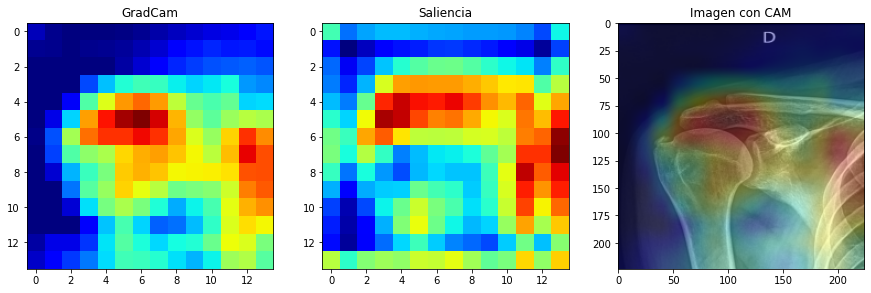

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 12 
Predice: 1 y es un 0


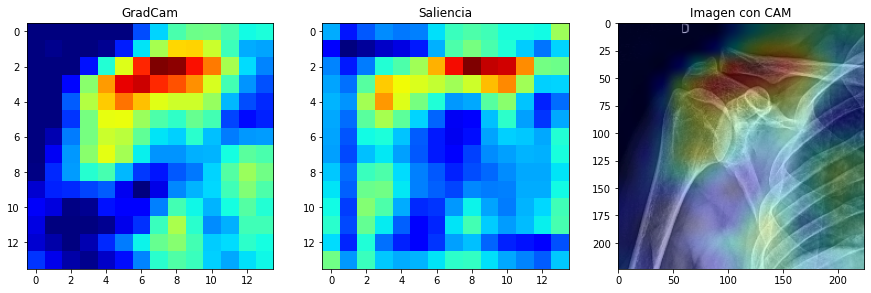

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 27 
Predice: 1 y es un 1


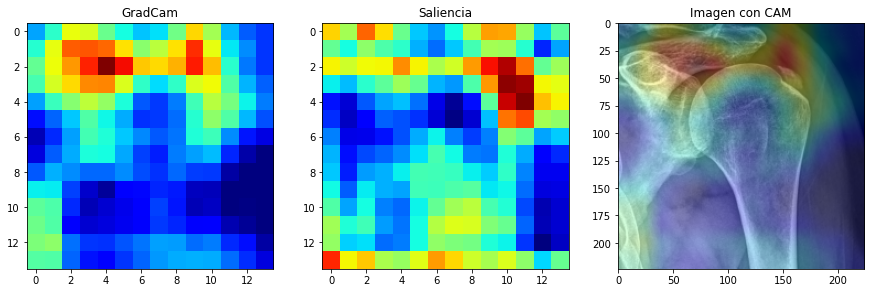

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 120 
Predice: 0 y es un 0


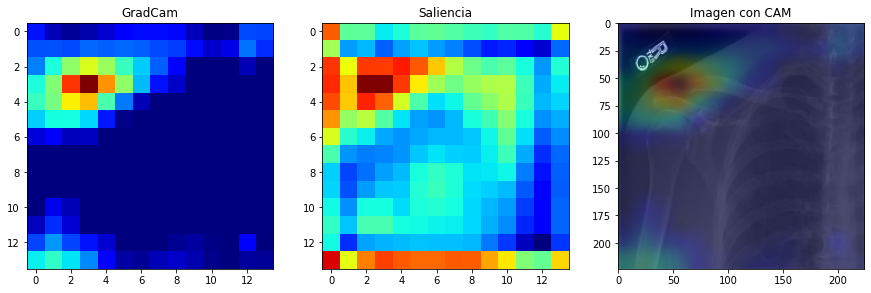

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 7 
Predice: 1 y es un 1


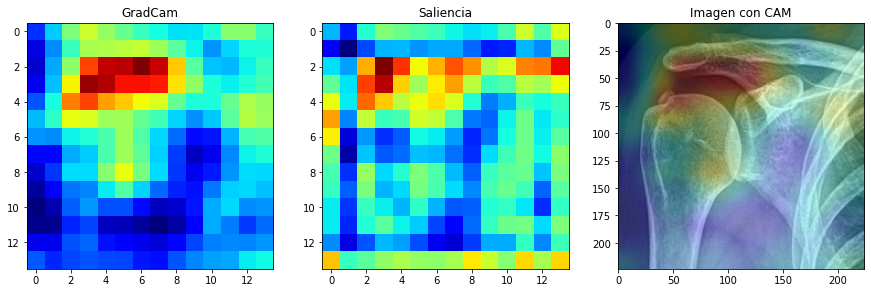

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 3 
Predice: 1 y es un 1


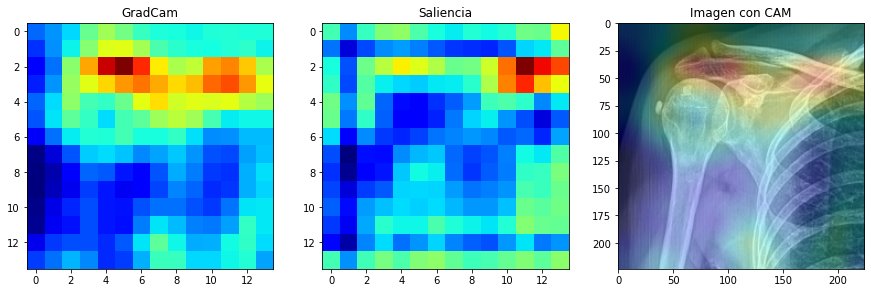

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 155 
Predice: 0 y es un 0


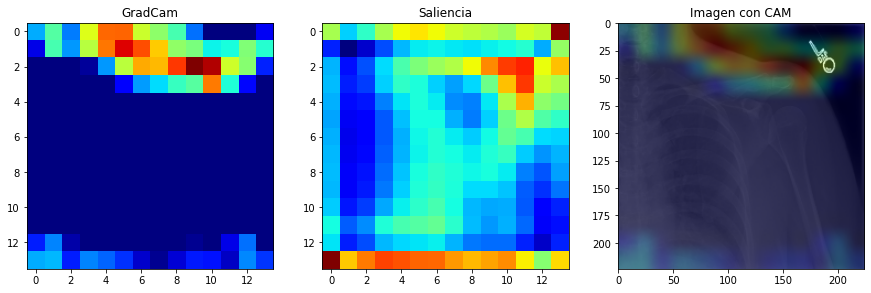

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 133 
Predice: 0 y es un 0


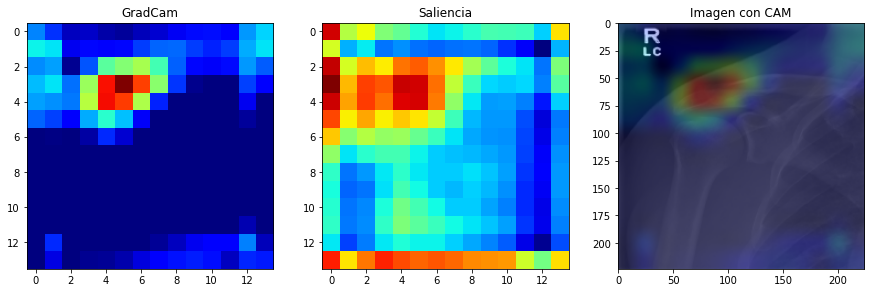

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 48 
Predice: 1 y es un 1


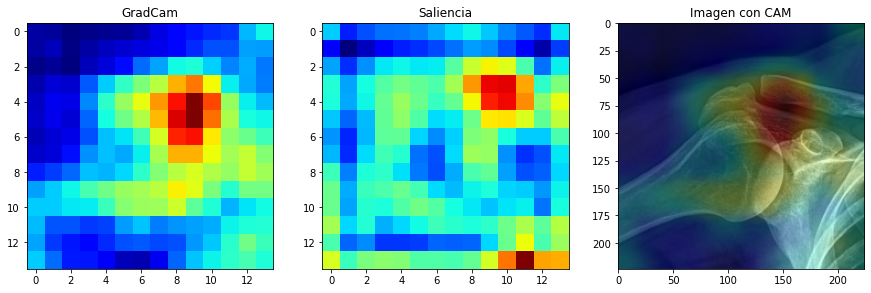

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 112 
Predice: 0 y es un 0


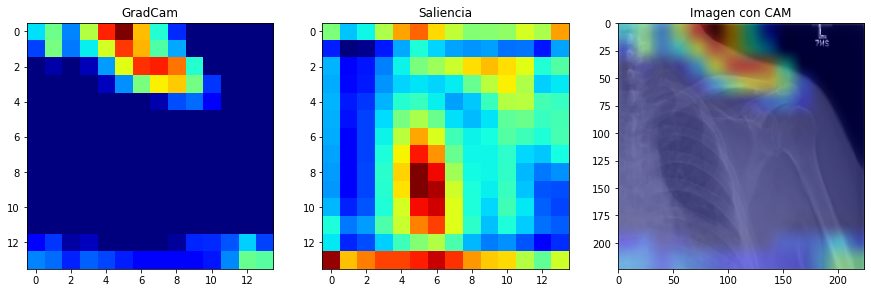

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 30 
Predice: 1 y es un 0


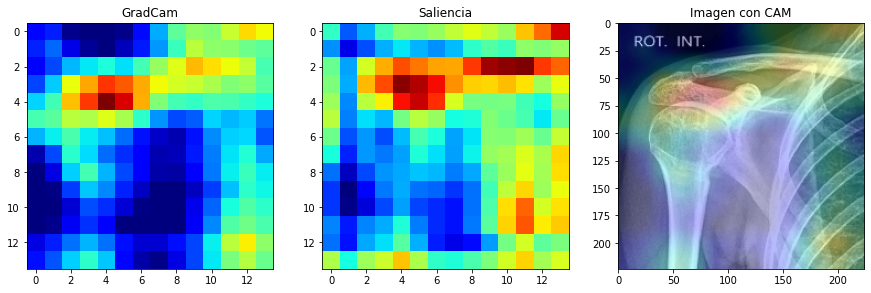

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 131 
Predice: 0 y es un 0


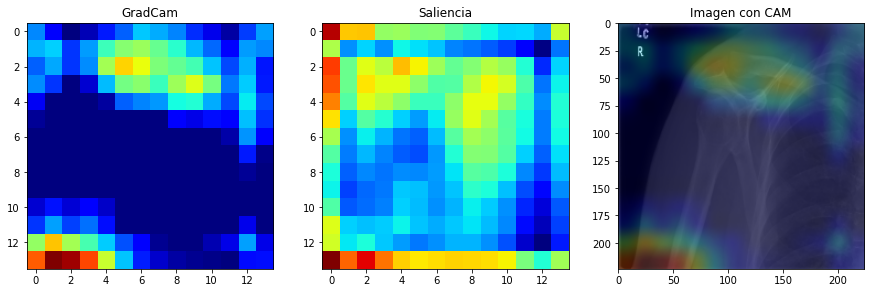

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 81 
Predice: 1 y es un 1


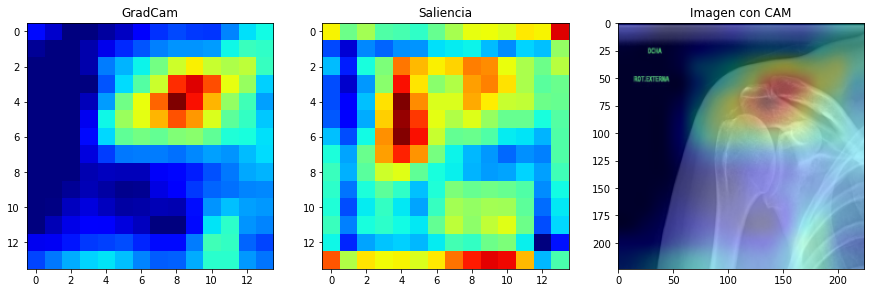

tf.Tensor(0, shape=(), dtype=int64)

Imagen de la base de datos nº: 64 
Predice: 1 y es un 1


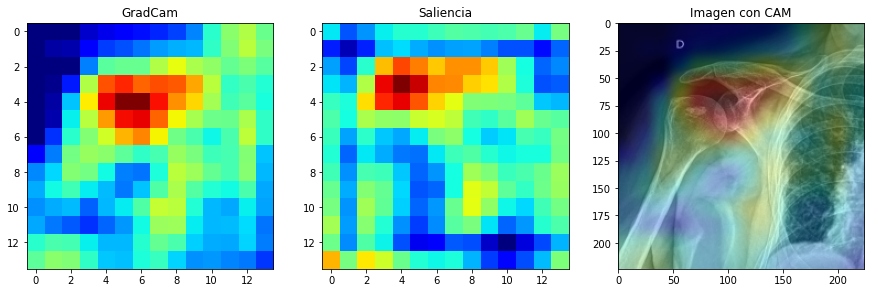

In [44]:
from PIL import Image
import matplotlib.cm as cm

scale=1
img_size  = (224,224,3)

model = model

preprocess_input   = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name   = 'block5_conv3'
classifier_layer_names =  ['block5_pool', 'flatten','dense_1','batch_normalization','dropout','output']

predicted = np.array([int(x[0] > 0.5) for x in model.predict(testX)])
for i in range(len(test_indices)):
  image = images[test_indices[i]]
  indice = test_indices[i]


  def get_img_array(img, size):
      array = keras.preprocessing.image.img_to_array(img)
      array = np.expand_dims(array, axis=0)
      return array

  img_array = get_img_array(img = image,size = (224,224))


  def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
      
      # Modelo que mapea la imagen de entrada a la capa convolucional última,
      # donde se calculará la activación
      last_conv_layer  = model.get_layer(last_conv_layer_name)
      conv_model       = keras.Model(model.inputs, last_conv_layer.output)

      # Modelo que mapea las activaciones a la salida final
      classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
      x = classifier_input
      for layer_name in classifier_layer_names:
          x = model.get_layer(layer_name)(x)
      classifier_model = keras.Model(classifier_input, x)
      
      # Cálculo del gradiente la salida  del modelo clasificador respecto a     
      with tf.GradientTape() as tape:
          
          # Calcula activacion del modelo base convolucional
          last_conv_layer_output = conv_model(img_array)
          tape.watch(last_conv_layer_output)
          
          # Calcula la predicción con modelo clasificador, para la clase mas probable
          preds = classifier_model(last_conv_layer_output)
          top_pred_index = tf.argmax(preds[0])
          print(top_pred_index)
          top_class_channel = preds[:, top_pred_index]

      # Obtenemos el gradiente en la capa final clasificadora con respecto a
      # la salida del modelo base convolucional
      grads = tape.gradient(top_class_channel, last_conv_layer_output)

      # Vector de pesos: medias del gradiente por capas,
      pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
      
      # salida de la última capa convolucional
      last_conv_layer_output = last_conv_layer_output.numpy()[0]
      
      # saliencia es la respuesta promedio de la última capa convolucional
      saliency = np.mean(last_conv_layer_output, axis=-1)
      saliency = np.maximum(saliency, 0) / np.max(saliency)
      
      # Multiplicación de cada canal por el vector de pesos
      pooled_grads = pooled_grads.numpy()
      for i in range(pooled_grads.shape[-1]):
          last_conv_layer_output[:, :, i] *= pooled_grads[i]
          
      # Heatmap: promedio de cada canal por su peso
      grad_cam = np.mean(last_conv_layer_output, axis=-1)
      grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
      
      return grad_cam, saliency


  grad_cam, saliency = make_gradcam_heatmap(img_array, 
                                            model, 
                                            last_conv_layer_name, 
                                            classifier_layer_names)
      
  def show_hotmap (img, heatmap, title='Heatmap', alpha=0.6, cmap='jet', axisOnOff='off'):
      '''
      img     :    Image
      heatmap :    2d narray
      '''
      resized_heatmap=resize(heatmap, img.size)
      
      fig, ax = plt.subplots()
      ax.imshow(img)
      ax.imshow(resized_heatmap, alpha=alpha, cmap=cmap)
      plt.axis(axisOnOff)
      plt.title(title)
      plt.show()

  img = keras.preprocessing.image.load_img(files[indice])
  img = keras.preprocessing.image.img_to_array(img)
  img_a=np.array(img)
  img = resize(img_a,(224,224))


  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * grad_cam)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
  #superimposed_img_res=resize(superimposed_img,(250,250))    

  print('\nImagen de la base de datos nº:', indice, '\nPredice:', predicted[i], 'y es un', labels[test_indices[i]])
  plt.figure(figsize=(15,15))
  plt.subplot(131)
  plt.imshow(grad_cam, 'jet')
  plt.title('GradCam')
  plt.subplot(132)
  plt.imshow(saliency, 'jet')
  plt.title('Saliencia')
  plt.subplot(133)
  plt.imshow(superimposed_img)
  plt.title('Imagen con CAM')
  plt.show()

Observamos que nuestro modelo se está fijando en el hombro en la mayoría de los casos, justo donde hay que fijarse para detectar si padece la enfermedad o no.